In [1]:
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import re
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import pickle as pkl

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Datasets/imdb_reviews.txt',sep = '\t',header=None)
df.head()

,0,1
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [3]:
df.columns = ['review','sentiment']
df.head()

,review,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [4]:
df['sentiment'].value_counts()

1    386
0    362
Name: sentiment, dtype: int64

    0 = Negative Sentiment
    1 = Positive Sentiment

# Data Cleaning

In [5]:
# removing special characters from reviews
def remove_special(x):
    spcl = r'[^\w]+'
    x = re.sub(spcl,' ',x)
    return x

# removing email
def remove_email(x):
    email = r'\S+@\S+'
    x = re.sub(email,' ',x)
    return x

# expand contractions
def cont_exp(x):
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how does",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    " u ": " you ",
    " ur ": " your ",
    " n ": " and ",
    "won't": "would not",
    'dis': 'this',
    'bak': 'back',
    'brng': 'bring'}

    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x


In [6]:
df.head()

,review,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [7]:
df['review'] = df['review'].apply(remove_special)
df['review'] = df['review'].apply(remove_email)
df['review'] = df['review'].apply(lambda x : str(x).lower())
df['review'] = df['review'].apply(cont_exp)

In [8]:
df.head()

,review,sentiment
0,a very very very slow moving aimless movie abo...,0
1,not sure who was more lost the flat characters...,0
2,attempting artiness with black white and cleve...,0
3,very little music or anything to speak of,0
4,the best scene in the movie was when gerardo i...,1


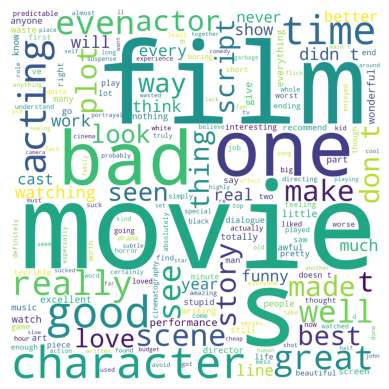

In [9]:
wc = WordCloud(scale=2,
               background_color='white',
               height= 900,
               width = 900).generate_from_text(' '.join(df['review']))
plt.imshow(wc)
plt.axis('off')
plt.show()

# Data Preparation

In [10]:
X = df['review']
y = df['sentiment']

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size= 0.8 , random_state= 0,stratify=y)

### Logistic Regression

In [12]:
pipe = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf',LogisticRegression(solver='liblinear'))
])

In [13]:
hyperparameters = {
    'tfidf__ngram_range': ((1,1),(1,2)),
    'tfidf__use_idf': (True,False),
    'tfidf__analyzer' : ('word', 'char', 'char_wb'),
    'clf__penalty' : ('l1','l2'),
    'clf__C' : (1,2) 
}

In [14]:
%%time
clf = GridSearchCV(pipe,hyperparameters,n_jobs=-1,cv = 5)
clf.fit(X_train,y_train)

Wall time: 3.41 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clf__C': (1, 2), 'clf__penalty': ('l1', 'l2'),
                         'tfidf__analyzer': ('word', 'char', 'char_wb'),
                         'tfidf__ngram_range': ((1, 1), (1, 2)),
                         'tfidf__use_idf': (True, False)})

In [15]:
clf.best_score_

0.7608683473389355

In [16]:
clf.best_params_

{'clf__C': 2,
 'clf__penalty': 'l2',
 'tfidf__analyzer': 'word',
 'tfidf__ngram_range': (1, 1),
 'tfidf__use_idf': True}

In [17]:
y_pred = clf.predict(X_test)

In [18]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.68      0.70        73
           1       0.71      0.74      0.73        77

    accuracy                           0.71       150
   macro avg       0.71      0.71      0.71       150
weighted avg       0.71      0.71      0.71       150



### RandomForestClassifier

In [19]:
pipe2 = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('rf',RandomForestClassifier())
])

In [20]:
hyperparameters2 = {
    'tfidf__ngram_range': ((1,1),(1,2)),
    'tfidf__use_idf': (True,False),
    'tfidf__analyzer' : ('word', 'char', 'char_wb'),
    'rf__n_estimators' : [100,200],
    'rf__max_depth' : [11,12],
    'rf__max_features' : ['auto','sqrt','log2'],
    'rf__criterion' : ['entropy','gini']
}

In [21]:
%%time
clf2 = GridSearchCV(pipe2,hyperparameters2,n_jobs=-1,cv = 5)
clf2.fit(X_train,y_train)

Wall time: 41.7 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['entropy', 'gini'],
                         'rf__max_depth': [11, 12],
                         'rf__max_features': ['auto', 'sqrt', 'log2'],
                         'rf__n_estimators': [100, 200],
                         'tfidf__analyzer': ('word', 'char', 'char_wb'),
                         'tfidf__ngram_range': ((1, 1), (1, 2)),
                         'tfidf__use_idf': (True, False)})

In [22]:
y_pred_rf = clf2.predict(X_test)

In [23]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68        73
           1       0.70      0.69      0.69        77

    accuracy                           0.69       150
   macro avg       0.69      0.69      0.69       150
weighted avg       0.69      0.69      0.69       150



In [24]:
clf2.best_params_

{'rf__criterion': 'entropy',
 'rf__max_depth': 12,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 200,
 'tfidf__analyzer': 'char_wb',
 'tfidf__ngram_range': (1, 2),
 'tfidf__use_idf': True}

In [25]:
clf2.best_score_

0.7357142857142858

### SVM

In [26]:
pipe3 = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf', LinearSVC())
])

In [27]:
hyperparameters3 = {
    'tfidf__ngram_range': ((1,1),(1,2)),
    'tfidf__use_idf': (True,False),
    'tfidf__analyzer' : ('word', 'char', 'char_wb'),
    'clf__C' : (1,2) 
}

In [28]:
%%time
clf3 = GridSearchCV(pipe3,hyperparameters3,n_jobs=-1,cv = 5)
clf3.fit(X_train,y_train)

Wall time: 615 ms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', LinearSVC())]),
             n_jobs=-1,
             param_grid={'clf__C': (1, 2),
                         'tfidf__analyzer': ('word', 'char', 'char_wb'),
                         'tfidf__ngram_range': ((1, 1), (1, 2)),
                         'tfidf__use_idf': (True, False)})

In [29]:
y_pred_svm = clf3.predict(X_test)

In [30]:
print(classification_report(y_test,y_pred_svm))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72        73
           1       0.74      0.70      0.72        77

    accuracy                           0.72       150
   macro avg       0.72      0.72      0.72       150
weighted avg       0.72      0.72      0.72       150



In [31]:
clf3.best_score_

0.7691736694677871

In [32]:
pkl.dump(clf3,open('Models/Imdb.pkl','wb'))

# Sentiment analysis using Word2Vec

In [33]:
df['review']

0      a very very very slow moving aimless movie abo...
1      not sure who was more lost the flat characters...
2      attempting artiness with black white and cleve...
3             very little music or anything to speak of 
4      the best scene in the movie was when gerardo i...
                             ...                        
743    i just got bored watching jessice lange take h...
744    unfortunately any virtue in this film s produc...
745                        in a word it is embarrassing 
746                                   exceptionally bad 
747    all in all its an insult to one s intelligence...
Name: review, Length: 748, dtype: object

In [34]:
nlp = spacy.load('en_core_web_lg')
def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return vec

In [35]:
df['vec'] = df['review'].apply(lambda x: get_vec(x))

In [36]:
df.head()

,review,sentiment,vec
0,a very very very slow moving aimless movie abo...,0,"[-1.2954112, 2.1474452, -3.065825, -1.0495986,..."
1,not sure who was more lost the flat characters...,0,"[-3.794328, 0.70210844, -2.5325108, 0.14926393..."
2,attempting artiness with black white and cleve...,0,"[-3.26869, -0.21575612, -1.9846934, -0.4807238..."
3,very little music or anything to speak of,0,"[-1.9868913, 2.2468886, -4.532146, -2.550426, ..."
4,the best scene in the movie was when gerardo i...,1,"[-1.0748299, 2.742419, -2.5380828, -1.3163186,..."


In [37]:
X = df['vec'].to_numpy()

# Adjust the data to as many rows but create only single column
X = X.reshape(-1,1)

In [38]:
df.shape

(748, 3)

In [39]:
X = np.concatenate(np.concatenate(X, axis = 0), axis = 0).reshape(-1, 300)

In [40]:
X

array([[-1.2954112 ,  2.1474452 , -3.065825  , ...,  1.3784506 ,
        -4.441238  ,  2.71472   ],
       [-3.794328  ,  0.70210844, -2.5325108 , ..., -1.3842818 ,
        -3.293052  ,  0.75865054],
       [-3.26869   , -0.21575612, -1.9846934 , ..., -1.8090384 ,
        -3.3651977 ,  0.22430795],
       ...,
       [-0.04726658,  4.9070535 , -1.2592984 , ..., -0.8263817 ,
        -3.2805035 ,  3.0998843 ],
       [-2.0310998 , -0.931085  , -1.41765   , ...,  2.633345  ,
        -2.109825  ,  4.57165   ],
       [-1.7334237 ,  1.4443806 , -1.5689337 , ..., -0.8330301 ,
        -5.1203814 ,  1.0205355 ]], dtype=float32)

In [41]:
# Columns
len(X[0])

300

In [42]:
# Rows
len(X)

748

# Logistic Regression

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [44]:
clf = LogisticRegression(solver = 'liblinear' )
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86        75
           1       0.84      0.91      0.87        75

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.87      0.87      0.87       150



In [45]:
from sklearn.model_selection import GridSearchCV

hyperparameters4 = {
    'penalty': ['l1', 'l2'],
    'C': (1, 2, 3, 4)
}


clf_lr_cv = GridSearchCV(clf,hyperparameters4,cv=5,n_jobs=-1)

clf_lr_cv.fit(X_train, y_train)

print('Best Params ',clf_lr_cv.best_params_)
print('Best Score', clf_lr_cv.best_score_)

y_pred = clf_lr_cv.predict(X_test)

print(classification_report(y_test, y_pred))

Best Params  {'C': 1, 'penalty': 'l1'}
Best Score 0.7758683473389356
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        75
           1       0.85      0.89      0.87        75

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.87      0.87      0.87       150



In [46]:
#!pip install lazypredict

In [47]:
from lazypredict.Supervised import LazyClassifier

In [48]:
lp_clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

In [49]:
models, predictions = lp_clf.fit(X_train, X_test,  y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00,  9.88it/s]


In [50]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.87,0.87,0.87,0.87,0.03
CalibratedClassifierCV,0.87,0.87,0.87,0.87,0.45
LinearSVC,0.86,0.86,0.86,0.86,0.11
RidgeClassifierCV,0.85,0.85,0.85,0.85,0.03
Perceptron,0.85,0.85,0.85,0.85,0.02
PassiveAggressiveClassifier,0.85,0.85,0.85,0.85,0.03
SGDClassifier,0.83,0.83,0.83,0.83,0.02
RidgeClassifier,0.81,0.81,0.81,0.81,0.01
NuSVC,0.80,0.80,0.80,0.80,0.05
